In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import lightgbm as lgb
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, Embedding, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2

In [2]:
suumo = pd.read_csv('./data/csv/SuumoDetailsFinal20221108.csv')

# 比較用　LightGBM

In [8]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
#    '歩', # 13
#    'バス', # 16
#    '車', # 2
    '最寄駅からの距離',
#    '部屋数', # 4
    '面積',
    '築年数',
#    '階数', # 5
#    '地下', # 17
    '地上',
    '階',
#    'オプション数', # 0
#    '駐車場距離', # 14
#    '駐車場料金', # 6
#    '条件数', # 9
]
category_features = [
    '市区町村',
    '路線',
    '駅',
    '間取り',
#    '向き', # 1
    '建物種別', # 10
    '構造',
#    '入居', # 15
#    '取引態様',
]
is_features = [
#    '間取り_S', # 11
#    '間取り_L', # 7
#    '間取り_D', # 12
#    '間取り_K', # 3
#    '駐車場有無', # 8
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [9]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'])

In [13]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(
    X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [16]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    n_estimators = 5000,
#    num_leaves = 1000, 
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0299088
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0253301
[3]	valid_0's l2: 0.0215658
[4]	valid_0's l2: 0.0184664
[5]	valid_0's l2: 0.0159211
[6]	valid_0's l2: 0.0137106
[7]	valid_0's l2: 0.0118926
[8]	valid_0's l2: 0.0103827
[9]	valid_0's l2: 0.00913653
[10]	valid_0's l2: 0.00812594
[11]	valid_0's l2: 0.00722829
[12]	valid_0's l2: 0.00647552
[13]	valid_0's l2: 0.00584686
[14]	valid_0's l2: 0.00532667
[15]	valid_0's l2: 0.00488295
[16]	valid_0's l2: 0.00450454
[17]	valid_0's l2: 0.00418269
[18]	valid_0's l2: 0.00389712
[19]	valid_0's l2: 0.00365075
[20]	valid_0's l2: 0.00344438
[21]	valid_0's l2: 0.0032662
[22]	valid_0's l2: 0.00310219
[23]	valid_0's l2: 0.00296577
[24]	valid_0's l2: 0.0028528
[25]	valid_0's l2: 0.00274823
[26]	valid_0's l2: 0.0026536
[27]	valid_0's l2: 0.00257275
[28]	valid_0's l2: 0.00250104
[29]	valid_0's l2: 0.00243596
[30]	valid_0's l2: 0.00237538
[31]	valid_0's l2: 0.00232211
[32]	valid_0's l2: 0.00227242

[273]	valid_0's l2: 0.0013991
[274]	valid_0's l2: 0.00139812
[275]	valid_0's l2: 0.00139736
[276]	valid_0's l2: 0.00139621
[277]	valid_0's l2: 0.00139573
[278]	valid_0's l2: 0.00139544
[279]	valid_0's l2: 0.00139491
[280]	valid_0's l2: 0.00139368
[281]	valid_0's l2: 0.00139329
[282]	valid_0's l2: 0.00139248
[283]	valid_0's l2: 0.00139117
[284]	valid_0's l2: 0.00139076
[285]	valid_0's l2: 0.00138999
[286]	valid_0's l2: 0.00138892
[287]	valid_0's l2: 0.00138857
[288]	valid_0's l2: 0.00138815
[289]	valid_0's l2: 0.00138723
[290]	valid_0's l2: 0.00138692
[291]	valid_0's l2: 0.0013862
[292]	valid_0's l2: 0.0013861
[293]	valid_0's l2: 0.00138553
[294]	valid_0's l2: 0.00138471
[295]	valid_0's l2: 0.00138367
[296]	valid_0's l2: 0.00138307
[297]	valid_0's l2: 0.00138257
[298]	valid_0's l2: 0.00138161
[299]	valid_0's l2: 0.00138131
[300]	valid_0's l2: 0.00138059
[301]	valid_0's l2: 0.00138035
[302]	valid_0's l2: 0.00137898
[303]	valid_0's l2: 0.00137841
[304]	valid_0's l2: 0.00137778
[305]	valid

[568]	valid_0's l2: 0.00125439
[569]	valid_0's l2: 0.00125409
[570]	valid_0's l2: 0.00125384
[571]	valid_0's l2: 0.00125357
[572]	valid_0's l2: 0.00125294
[573]	valid_0's l2: 0.00125268
[574]	valid_0's l2: 0.00125239
[575]	valid_0's l2: 0.00125163
[576]	valid_0's l2: 0.00125151
[577]	valid_0's l2: 0.00125135
[578]	valid_0's l2: 0.00125101
[579]	valid_0's l2: 0.00125054
[580]	valid_0's l2: 0.00125067
[581]	valid_0's l2: 0.00125033
[582]	valid_0's l2: 0.00124972
[583]	valid_0's l2: 0.00124931
[584]	valid_0's l2: 0.00124908
[585]	valid_0's l2: 0.0012487
[586]	valid_0's l2: 0.0012485
[587]	valid_0's l2: 0.00124811
[588]	valid_0's l2: 0.00124797
[589]	valid_0's l2: 0.00124776
[590]	valid_0's l2: 0.00124759
[591]	valid_0's l2: 0.00124775
[592]	valid_0's l2: 0.00124737
[593]	valid_0's l2: 0.00124722
[594]	valid_0's l2: 0.00124696
[595]	valid_0's l2: 0.00124684
[596]	valid_0's l2: 0.0012468
[597]	valid_0's l2: 0.00124657
[598]	valid_0's l2: 0.00124619
[599]	valid_0's l2: 0.00124581
[600]	valid

[871]	valid_0's l2: 0.00117861
[872]	valid_0's l2: 0.00117831
[873]	valid_0's l2: 0.00117791
[874]	valid_0's l2: 0.00117783
[875]	valid_0's l2: 0.0011776
[876]	valid_0's l2: 0.00117737
[877]	valid_0's l2: 0.00117738
[878]	valid_0's l2: 0.001177
[879]	valid_0's l2: 0.00117681
[880]	valid_0's l2: 0.00117671
[881]	valid_0's l2: 0.00117655
[882]	valid_0's l2: 0.00117631
[883]	valid_0's l2: 0.00117604
[884]	valid_0's l2: 0.0011759
[885]	valid_0's l2: 0.00117566
[886]	valid_0's l2: 0.00117517
[887]	valid_0's l2: 0.00117497
[888]	valid_0's l2: 0.00117465
[889]	valid_0's l2: 0.00117436
[890]	valid_0's l2: 0.00117418
[891]	valid_0's l2: 0.0011741
[892]	valid_0's l2: 0.00117378
[893]	valid_0's l2: 0.00117358
[894]	valid_0's l2: 0.00117333
[895]	valid_0's l2: 0.0011729
[896]	valid_0's l2: 0.0011727
[897]	valid_0's l2: 0.00117252
[898]	valid_0's l2: 0.00117214
[899]	valid_0's l2: 0.0011719
[900]	valid_0's l2: 0.00117178
[901]	valid_0's l2: 0.00117172
[902]	valid_0's l2: 0.00117148
[903]	valid_0's 

[1177]	valid_0's l2: 0.00112043
[1178]	valid_0's l2: 0.00112025
[1179]	valid_0's l2: 0.00112018
[1180]	valid_0's l2: 0.0011201
[1181]	valid_0's l2: 0.00111998
[1182]	valid_0's l2: 0.00111978
[1183]	valid_0's l2: 0.00111967
[1184]	valid_0's l2: 0.00111952
[1185]	valid_0's l2: 0.00111933
[1186]	valid_0's l2: 0.00111921
[1187]	valid_0's l2: 0.00111918
[1188]	valid_0's l2: 0.00111919
[1189]	valid_0's l2: 0.00111915
[1190]	valid_0's l2: 0.00111904
[1191]	valid_0's l2: 0.00111893
[1192]	valid_0's l2: 0.00111884
[1193]	valid_0's l2: 0.00111864
[1194]	valid_0's l2: 0.00111849
[1195]	valid_0's l2: 0.00111834
[1196]	valid_0's l2: 0.00111822
[1197]	valid_0's l2: 0.00111815
[1198]	valid_0's l2: 0.00111807
[1199]	valid_0's l2: 0.00111787
[1200]	valid_0's l2: 0.0011178
[1201]	valid_0's l2: 0.00111763
[1202]	valid_0's l2: 0.00111736
[1203]	valid_0's l2: 0.00111726
[1204]	valid_0's l2: 0.00111685
[1205]	valid_0's l2: 0.00111663
[1206]	valid_0's l2: 0.00111648
[1207]	valid_0's l2: 0.00111611
[1208]	val

[1482]	valid_0's l2: 0.00108453
[1483]	valid_0's l2: 0.00108443
[1484]	valid_0's l2: 0.00108419
[1485]	valid_0's l2: 0.00108405
[1486]	valid_0's l2: 0.0010839
[1487]	valid_0's l2: 0.00108382
[1488]	valid_0's l2: 0.00108368
[1489]	valid_0's l2: 0.00108356
[1490]	valid_0's l2: 0.00108338
[1491]	valid_0's l2: 0.0010833
[1492]	valid_0's l2: 0.00108319
[1493]	valid_0's l2: 0.00108306
[1494]	valid_0's l2: 0.00108294
[1495]	valid_0's l2: 0.00108288
[1496]	valid_0's l2: 0.0010828
[1497]	valid_0's l2: 0.00108268
[1498]	valid_0's l2: 0.00108248
[1499]	valid_0's l2: 0.00108231
[1500]	valid_0's l2: 0.00108217
[1501]	valid_0's l2: 0.00108199
[1502]	valid_0's l2: 0.00108194
[1503]	valid_0's l2: 0.0010818
[1504]	valid_0's l2: 0.00108154
[1505]	valid_0's l2: 0.00108144
[1506]	valid_0's l2: 0.0010812
[1507]	valid_0's l2: 0.00108109
[1508]	valid_0's l2: 0.00108091
[1509]	valid_0's l2: 0.00108075
[1510]	valid_0's l2: 0.00108054
[1511]	valid_0's l2: 0.00108037
[1512]	valid_0's l2: 0.0010803
[1513]	valid_0

[1770]	valid_0's l2: 0.00105025
[1771]	valid_0's l2: 0.00105017
[1772]	valid_0's l2: 0.00105009
[1773]	valid_0's l2: 0.00104994
[1774]	valid_0's l2: 0.0010499
[1775]	valid_0's l2: 0.00104969
[1776]	valid_0's l2: 0.00104952
[1777]	valid_0's l2: 0.00104939
[1778]	valid_0's l2: 0.00104968
[1779]	valid_0's l2: 0.00104956
[1780]	valid_0's l2: 0.00104944
[1781]	valid_0's l2: 0.00104932
[1782]	valid_0's l2: 0.00104918
[1783]	valid_0's l2: 0.00104909
[1784]	valid_0's l2: 0.00104899
[1785]	valid_0's l2: 0.00104885
[1786]	valid_0's l2: 0.0010487
[1787]	valid_0's l2: 0.00104846
[1788]	valid_0's l2: 0.00104829
[1789]	valid_0's l2: 0.00104824
[1790]	valid_0's l2: 0.001048
[1791]	valid_0's l2: 0.00104786
[1792]	valid_0's l2: 0.00104784
[1793]	valid_0's l2: 0.0010477
[1794]	valid_0's l2: 0.00104756
[1795]	valid_0's l2: 0.00104751
[1796]	valid_0's l2: 0.00104734
[1797]	valid_0's l2: 0.00104723
[1798]	valid_0's l2: 0.00104711
[1799]	valid_0's l2: 0.00104706
[1800]	valid_0's l2: 0.00104696
[1801]	valid_

[2057]	valid_0's l2: 0.00102112
[2058]	valid_0's l2: 0.00102104
[2059]	valid_0's l2: 0.00102086
[2060]	valid_0's l2: 0.00102079
[2061]	valid_0's l2: 0.00102073
[2062]	valid_0's l2: 0.00102048
[2063]	valid_0's l2: 0.00102033
[2064]	valid_0's l2: 0.00102017
[2065]	valid_0's l2: 0.00101994
[2066]	valid_0's l2: 0.00101982
[2067]	valid_0's l2: 0.00101976
[2068]	valid_0's l2: 0.00101968
[2069]	valid_0's l2: 0.00101958
[2070]	valid_0's l2: 0.00101952
[2071]	valid_0's l2: 0.00101944
[2072]	valid_0's l2: 0.00101921
[2073]	valid_0's l2: 0.00101907
[2074]	valid_0's l2: 0.00101894
[2075]	valid_0's l2: 0.00101883
[2076]	valid_0's l2: 0.00101873
[2077]	valid_0's l2: 0.00101871
[2078]	valid_0's l2: 0.00101851
[2079]	valid_0's l2: 0.00101837
[2080]	valid_0's l2: 0.00101836
[2081]	valid_0's l2: 0.00101832
[2082]	valid_0's l2: 0.00101822
[2083]	valid_0's l2: 0.00101809
[2084]	valid_0's l2: 0.00101798
[2085]	valid_0's l2: 0.00101786
[2086]	valid_0's l2: 0.00101779
[2087]	valid_0's l2: 0.00101768
[2088]	v

LGBMRegressor(importance_type='gain', n_estimators=5000, random_state=0)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

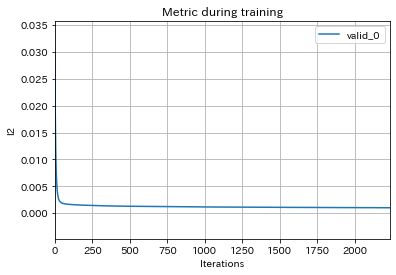

In [18]:
lgb.plot_metric(LGBM)

In [19]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [21]:
# それぞれのr2スコアを算出
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9887107295151344
valid: 0.9695107151350383
test: 0.961437180987307


In [22]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 0.6837918212386788
valid: 1.9607326384677803
test: 2.588772545079065


In [57]:
# それぞれのMSEを算出
# 対数変換なし
print('train:',mean_squared_error(y_train,y_train_pred))
print('valid:',mean_squared_error(y_valid,y_valid_pred))
print('test:',mean_squared_error(y_test,y_test_pred))

train: 0.00045123889035880715
valid: 0.001005815526037109
test: 0.001020489039728324


In [56]:
# それぞれのMAEを算出
print('train:',mean_absolute_error(10**y_train,10**y_train_pred))
print('valid:',mean_absolute_error(10**y_valid,10**y_valid_pred))
print('test:',mean_absolute_error(10**y_test,10**y_test_pred))

train: 0.35840724030172
valid: 0.5350493097193587
test: 0.5529255361377866


In [58]:
# それぞれのMAEを算出
print('train:',mean_absolute_error(y_train,y_train_pred))
print('valid:',mean_absolute_error(y_valid,y_valid_pred))
print('test:',mean_absolute_error(y_test,y_test_pred))

train: 0.014782927583911537
valid: 0.02098299072622341
test: 0.02121287106434343


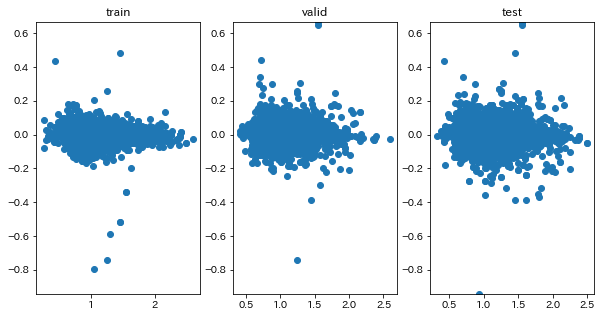

In [23]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train
error_valid = y_valid_pred - y_valid
error_test = y_test_pred - y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [25]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances = table_importances.sort_values('importance')
table_importances

,feature,importance
10,建物種別,19.519489
1,最寄駅からの距離,96.552352
7,路線,105.027131
5,階,119.719957
0,皇居からの距離,214.233940
11,構造,261.750099
4,地上,276.206803
3,築年数,1246.238831
8,駅,1465.169053
6,市区町村,2069.713720


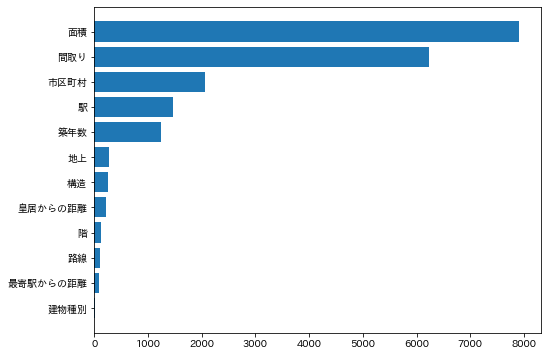

In [26]:
# 変数重要度
plt.figure(figsize=(8,6))
plt.barh(table_importances['feature'],table_importances['importance'])
plt.savefig("./data/image/elite_feature_importances.png")
plt.show()

# DeepNeuralNetwork OneHot

In [709]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
#    '歩', # 13
#    'バス', # 16
#    '車', # 2
    '最寄駅からの距離',
#    '部屋数', # 4
    '面積',
    '築年数',
#    '階数', # 5
#    '地下', # 17
    '地上',
    '階',
#    'オプション数', # 0
#    '駐車場距離', # 14
#    '駐車場料金', # 6
#    '条件数', # 9
]
category_features = [
    '市区町村',
#    '路線',
#    '駅',
    '間取り',
#    '向き', # 1
    '建物種別', # 10
    '構造',
#    '入居', # 15
#    '取引態様',
]
is_features = [
#    '間取り_S', # 11
#    '間取り_L', # 7
#    '間取り_D', # 12
#    '間取り_K', # 3
#    '駐車場有無', # 8
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数はOneHotEncoding
suumo_light_category_ohe = pd.get_dummies(suumo_light[category_features])


In [710]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'], )

In [711]:
# Xとyを定義
X = pd.merge(
    suumo_light[quantity_features],
    suumo_light_category_ohe,
    left_index=True, right_index=True
)
y = suumo_light[target_feature].values


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(
    X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [712]:
# 標準化
ss = StandardScaler()
ss.fit(X_train[quantity_features])
X_train[quantity_features] = ss.transform(X_train[quantity_features])
X_valid[quantity_features] = ss.transform(X_valid[quantity_features])
X_test[quantity_features] = ss.transform(X_test[quantity_features])

# X_train_before[quantity_feature] = ss.fit_transform(X_train_before[quantity_feature])
# X_test[quantity_feature] = ss.fit_transform(X_test[quantity_feature])

In [1185]:
# ニューラルネットモデル構築

input_dim = X.columns.shape[0]
layer1_newrons = 200
dropout1_rate = 0.2
layer2_newrons = 200
dropout2_rate= 0.8
layer3_newrons = 200
dropout3_rate= 0.8
output_results = 1
l2_size = 0
learning_rate = 0.0001
batch_size = 20

model = Sequential([
    Dense(layer1_newrons, kernel_regularizer=l2(l2_size), input_dim=input_dim),
    Activation('relu'),
#    Dropout(dropout1_rate),
    Dense(layer2_newrons, kernel_regularizer=l2(l2_size),),
    Activation('relu'),
#    Dropout(dropout2_rate),
    Dense(layer3_newrons, kernel_regularizer=l2(l2_size),),
    Activation('relu'),
#    Dropout(dropout3_rate),
    Dense(output_results, activation='linear')
])

optimizer = Adam(
    learning_rate = learning_rate,
)

model.compile(optimizer=optimizer,
             loss="mse",
             metrics="mae")

In [1186]:
model.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_200 (Dense)           (None, 200)               18200     
                                                                 
 activation_88 (Activation)  (None, 200)               0         
                                                                 
 dense_201 (Dense)           (None, 200)               40200     
                                                                 
 activation_89 (Activation)  (None, 200)               0         
                                                                 
 dense_202 (Dense)           (None, 200)               40200     
                                                                 
 activation_90 (Activation)  (None, 200)               0         
                                                                 
 dense_203 (Dense)           (None, 1)               

In [1187]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
    epochs=100,
    verbose=1,
    callbacks=[es]
)

Epoch 1/100
5491/5491 [==============================] - 25s 4ms/step - loss: 0.0083 - mae: 0.0530 - val_loss: 0.0025 - val_mae: 0.0372
Epoch 2/100
5491/5491 [==============================] - 22s 4ms/step - loss: 0.0025 - mae: 0.0370 - val_loss: 0.0022 - val_mae: 0.0345
Epoch 3/100
5491/5491 [==============================] - 23s 4ms/step - loss: 0.0022 - mae: 0.0350 - val_loss: 0.0023 - val_mae: 0.0357
Epoch 4/100
5491/5491 [==============================] - 22s 4ms/step - loss: 0.0021 - mae: 0.0340 - val_loss: 0.0020 - val_mae: 0.0334
Epoch 5/100
5491/5491 [==============================] - 24s 4ms/step - loss: 0.0020 - mae: 0.0331 - val_loss: 0.0021 - val_mae: 0.0338
Epoch 6/100
5491/5491 [==============================] - 22s 4ms/step - loss: 0.0019 - mae: 0.0325 - val_loss: 0.0020 - val_mae: 0.0331
Epoch 7/100
5491/5491 [==============================] - 22s 4ms/step - loss: 0.0019 - mae: 0.0319 - val_loss: 0.0019 - val_mae: 0.0324
Epoch 8/100
5491/5491 [=========================

In [1188]:
score = model.evaluate(X_test, y_test, batch_size=batch_size)
print('test_mae',score[1])

2942/2942 [==============================] - 12s 4ms/step - loss: 0.0015 - mae: 0.0281
test_mae 0.02808484435081482


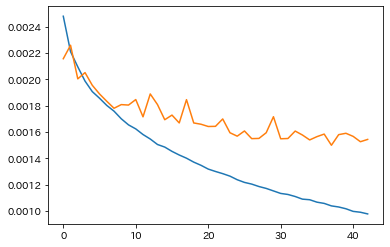

In [1189]:
# 損失関数の学習曲線
slide = 1
ranges = hist.epoch[-1] - (slide - 1)

plt.plot(range(ranges),hist.history['loss'][slide:])
plt.plot(range(ranges),hist.history['val_loss'][slide:])
plt.show()

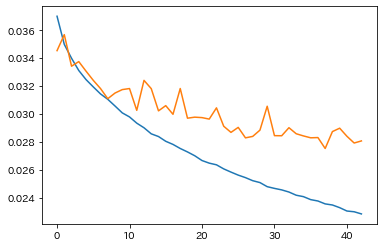

In [1190]:
# 評価関数の学習曲線
plt.plot(range(ranges),hist.history['mae'][slide:])
plt.plot(range(ranges),hist.history['val_mae'][slide:])
plt.show()

In [1191]:
# それぞれの予測結果を収納
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

1839/1839 [==============================] - 6s 3ms/step


In [1192]:
# それぞれのr2スコアを算出
print('train:',r2_score(10**np.array(y_train).reshape(-1,1),10**y_train_pred))
print('valid:',r2_score(10**np.array(y_valid).reshape(-1,1),10**y_valid_pred))
print('test:',r2_score(10**np.array(y_test).reshape(-1,1),10**y_test_pred))

train: 0.9590649376768949
valid: 0.9468352140436422
test: 0.9244521053038247


In [1193]:
# 前回の記録:r2スコア
# L2正則化 ：0
# 学習率：0.0001
# エポック数：50
# ニューロン：200,2


# train: 0.9585757834232139
# valid: 0.940813816342447
# test: 0.9450601521901051

In [1194]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 2.479439292021539
valid: 3.4189693691890697
test: 5.071629114137339


In [1195]:
# 前回の記録:MSE
# L2正則化 ：なし
# 学習率：0.0001
# エポック数：50
# ニューロン：200,2


# train: 2.5090673958427367
# valid: 3.8061988845489516
# test: 3.688183936819138

In [1196]:
# それぞれのMAEを算出
print('train:',mean_absolute_error(10**y_train,10**y_train_pred))
print('valid:',mean_absolute_error(10**y_valid,10**y_valid_pred))
print('test:',mean_absolute_error(10**y_test,10**y_test_pred))

train: 0.5829268371398838
valid: 0.7405733487225055
test: 0.7578217767644578


In [1197]:
# 前回の記録:MAE
# L2正則化 ：なし
# 学習率：0.0001
# エポック数：50
# ニューロン：30,2


# train: 0.7383698931278974
# valid: 0.8219758212023153
# test: 0.8372292825980668

In [1198]:
# それぞれのr2スコアを算出
# 対数変換なし
print('train:',r2_score(np.array(y_train).reshape(-1,1),y_train_pred))
print('valid:',r2_score(np.array(y_valid).reshape(-1,1),y_valid_pred))
print('test:',r2_score(np.array(y_test).reshape(-1,1),y_test_pred))

train: 0.9735281950010534
valid: 0.9564991584970107
test: 0.9569798818387526


In [1199]:
# それぞれのMSEを算出
# 対数変換なし
print('train:',mean_squared_error(y_train,y_train_pred))
print('valid:',mean_squared_error(y_valid,y_valid_pred))
print('test:',mean_squared_error(y_test,y_test_pred))

train: 0.0009311581552759416
valid: 0.0015435911534391036
test: 0.001548025795579844


In [1200]:
# それぞれのMAEを算出
# 対数変換なし
print('train:',mean_absolute_error(y_train,y_train_pred))
print('valid:',mean_absolute_error(y_valid,y_valid_pred))
print('test:',mean_absolute_error(y_test,y_test_pred))

train: 0.022358278213950953
valid: 0.028083606446543407
test: 0.02808483499851063


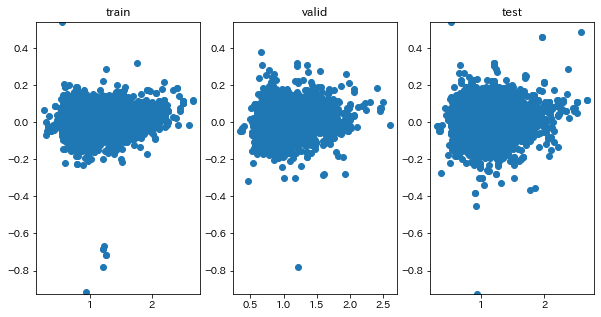

In [1201]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - np.array(y_train).reshape(-1,1)
error_valid = y_valid_pred - np.array(y_valid).reshape(-1,1)
error_test = y_test_pred - np.array(y_test).reshape(-1,1)

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [1150]:
print(suumo.loc[60568,'url'])

https://suumo.jp/chintai/jnc_000077468067/?bc=100301416041


# NeuralNet Embedding

In [3]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
#    '歩', # 13
#    'バス', # 16
#    '車', # 2
    '最寄駅からの距離',
#    '部屋数', # 4
    '面積',
    '築年数',
#    '階数', # 5
#    '地下', # 17
    '地上',
    '階',
#    'オプション数', # 0
#    '駐車場距離', # 14
#    '駐車場料金', # 6
#    '条件数', # 9
]
category_features = [
    '市区町村',
    '路線',
    '駅',
    '間取り',
#    '向き', # 1
    '建物種別', # 10
    '構造',
#    '入居', # 15
#    '取引態様',
]
is_features = [
#    '間取り_S', # 11
#    '間取り_L', # 7
#    '間取り_D', # 12
#    '間取り_K', # 3
#    '駐車場有無', # 8
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]


In [4]:
# カテゴリ変数をEmbedding したい
# ラベルエンコード→Embeddingにいれる

LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")


In [5]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'], )

In [6]:
# Xとyを定義
X = pd.merge(
    suumo_light[quantity_features],
    suumo_light[category_features],
    left_index=True, right_index=True
)
y = suumo_light[target_feature].values


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test_before, y_train_before, y_test = train_test_split(
    X, y, train_size = train_test, random_state = 0)
X_test = copy.copy(X_test_before)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [7]:
# カテゴリ変数をEmbeddingで変換

for feature in category_features:

    input_dim = suumo_light[feature].unique().shape[0]
    output_dim = 2
    # Embedding層を作る　作り直しに注意！再現できなくなる
    exec(f"Embedding_{feature} = Sequential([Input(shape=(1,)),Embedding(input_dim = input_dim,output_dim = output_dim),Flatten(),])")
    # Embedding
    exec(f"X_train[[f'{feature}_0',f'{feature}_1']] = Embedding_{feature}(X_train[feature].values)")
    exec(f"X_valid[[f'{feature}_0',f'{feature}_1']] = Embedding_{feature}(X_valid[feature].values)")
    exec(f"X_test[[f'{feature}_0',f'{feature}_1']] = Embedding_{feature}(X_test[feature].values)")
    # いらない変数を落とす
    X_train.drop(feature,axis=1, inplace=True)
    X_valid.drop(feature,axis=1, inplace=True)
    X_test.drop(feature,axis=1, inplace=True)
    

In [8]:
# 標準化
ss = StandardScaler()
ss.fit(X_train[quantity_features])
X_train[quantity_features] = ss.transform(X_train[quantity_features])
X_valid[quantity_features] = ss.transform(X_valid[quantity_features])
X_test[quantity_features] = ss.transform(X_test[quantity_features])

# X_train_before[quantity_feature] = ss.fit_transform(X_train_before[quantity_feature])
# X_test_before[quantity_feature] = ss.fit_transform(X_test_before[quantity_feature])

In [9]:
# モデル構築
input_shape = X_train.columns.shape
input_dim = X_train.columns.shape[0]
newrons1 = 120
newrons2 = 120
newrons3 = 120
newrons4 = 120
output_results = 1
l2_size = 0
learning_rate = 0.001
epochs = 200
batch_size = 100

model = Sequential([
    Dropout(0.2, input_shape=X_train.columns.shape),
    Dense(newrons1,kernel_regularizer=l2(l2_size), input_dim=input_dim),
    Activation('relu'),
    Dropout(0.5),
    Dense(newrons2,kernel_regularizer=l2(l2_size),),
    Activation('relu'),
    Dropout(0.5),
    Dense(newrons3,kernel_regularizer=l2(l2_size),),
    Activation('relu'),
    Dropout(0.5),
    Dense(newrons4,kernel_regularizer=l2(l2_size),),
    Activation('relu'),
    Dropout(0.5),
    Dense(newrons4,kernel_regularizer=l2(l2_size),),
    Activation('relu'),
    Dropout(0.5),
    Dense(newrons4,kernel_regularizer=l2(l2_size),),
    Activation('relu'),
    Dense(output_results, activation='linear'),
])

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="mse",
    metrics="mae",
)

In [11]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 18)                0         
                                                                 
 dense (Dense)               (None, 120)               2280      
                                                                 
 activation (Activation)     (None, 120)               0         
                                                                 
 dropout_1 (Dropout)         (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 activation_1 (Activation)   (None, 120)               0         
                                                                 
 dropout_2 (Dropout)         (None, 120)              

In [12]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

hist = model.fit(
    x = X_train, y = y_train,
    validation_data = (X_valid,y_valid),
    batch_size = batch_size,
    epochs = epochs,
    verbose = 1,
    callbacks = es
)

Epoch 1/200
1099/1099 [==============================] - 10s 8ms/step - loss: 0.0462 - mae: 0.1418 - val_loss: 0.0218 - val_mae: 0.1008
Epoch 2/200
1099/1099 [==============================] - 8s 7ms/step - loss: 0.0165 - mae: 0.0941 - val_loss: 0.0186 - val_mae: 0.0952
Epoch 3/200
1099/1099 [==============================] - 8s 7ms/step - loss: 0.0138 - mae: 0.0855 - val_loss: 0.0174 - val_mae: 0.0900
Epoch 4/200
1099/1099 [==============================] - 8s 7ms/step - loss: 0.0122 - mae: 0.0808 - val_loss: 0.0158 - val_mae: 0.0845
Epoch 5/200
1099/1099 [==============================] - 8s 7ms/step - loss: 0.0116 - mae: 0.0786 - val_loss: 0.0139 - val_mae: 0.0825
Epoch 6/200
1099/1099 [==============================] - 9s 9ms/step - loss: 0.0114 - mae: 0.0773 - val_loss: 0.0149 - val_mae: 0.0907
Epoch 7/200
1099/1099 [==============================] - 8s 8ms/step - loss: 0.0111 - mae: 0.0765 - val_loss: 0.0127 - val_mae: 0.0825
Epoch 8/200
1099/1099 [==============================]

In [13]:
score = model.evaluate(X_test, y_test, batch_size=batch_size)
print('test_mae',score[1])

589/589 [==============================] - 1s 2ms/step - loss: 0.0133 - mae: 0.0903
test_mae 0.09027239680290222


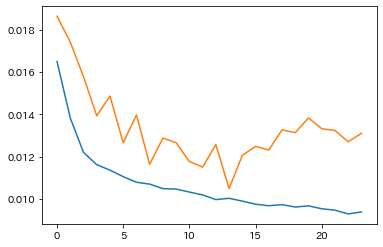

In [14]:
# 損失関数の学習曲線
slide = 1
ranges = hist.epoch[-1] - (slide - 1)

plt.plot(range(ranges),hist.history['loss'][slide:])
plt.plot(range(ranges),hist.history['val_loss'][slide:])
plt.show()

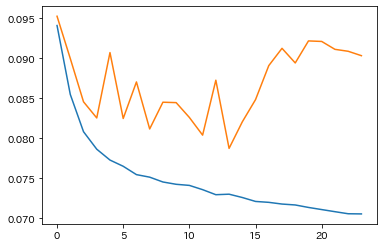

In [15]:
# 評価関数の学習曲線
plt.plot(range(ranges),hist.history['mae'][slide:])
plt.plot(range(ranges),hist.history['val_mae'][slide:])
plt.show()

In [16]:
# それぞれの予測結果を収納
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)

1839/1839 [==============================] - 3s 2ms/step


In [17]:
# それぞれのr2スコアを算出
print('train:',r2_score(10**np.array(y_train).reshape(-1,1),10**y_train_pred))
print('valid:',r2_score(10**np.array(y_valid).reshape(-1,1),10**y_valid_pred))
print('test:',r2_score(10**np.array(y_test).reshape(-1,1),10**y_test_pred))

train: 0.38543860410032904
valid: 0.3689121586657603
test: 0.3713159792684515


In [18]:
# 前回の記録:r2スコア
# L2正則化 ：0
# 学習率：0.001
# エポック数：100
# ニューロン：150,3


train: 0.9453586105774809
valid: 0.9310619594620086
test: 0.9342648619364569

In [19]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 37.22402228988879
valid: 40.584570406445735
test: 42.20438168340466


In [20]:
# 前回の記録:MSE
# L2正則化 ：なし
# 学習率：0.001
# エポック数：100
# ニューロン：150,3


train: 3.309632383981366
valid: 4.4333301588910246
test: 4.412885909867466

In [21]:
# それぞれのMAEを算出
print('train:',mean_absolute_error(10**y_train,10**y_train_pred))
print('valid:',mean_absolute_error(10**y_valid,10**y_valid_pred))
print('test:',mean_absolute_error(10**y_test,10**y_test_pred))

train: 2.4419512585980843
valid: 2.4578974351899263
test: 2.4978568611208565


In [22]:
# 前回の記録:MAE
# L2正則化 ：なし
# 学習率：0.001
# エポック数：100
# ニューロン：150,3


train: 0.7714047292556085
valid: 0.8267546747704609
test: 0.8442585992474295

In [23]:
# それぞれのr2スコアを算出
# 対数変換なし
print('train:',r2_score(np.array(y_train).reshape(-1,1),y_train_pred))
print('valid:',r2_score(np.array(y_valid).reshape(-1,1),y_valid_pred))
print('test:',r2_score(np.array(y_test).reshape(-1,1),y_test_pred))

train: 0.6301648335123659
valid: 0.6308097135586419
test: 0.631218501980169


In [24]:
# それぞれのMSEを算出
# 対数変換なし
print('train:',mean_squared_error(y_train,y_train_pred))
print('valid:',mean_squared_error(y_valid,y_valid_pred))
print('test:',mean_squared_error(y_test,y_test_pred))

train: 0.013009125422180313
valid: 0.013100410024191574
test: 0.01327014653301274


In [25]:
# それぞれのMAEを算出
# 対数変換なし
print('train:',mean_absolute_error(y_train,y_train_pred))
print('valid:',mean_absolute_error(y_valid,y_valid_pred))
print('test:',mean_absolute_error(y_test,y_test_pred))

train: 0.0898262884644017
valid: 0.09031221366314131
test: 0.0902723806572


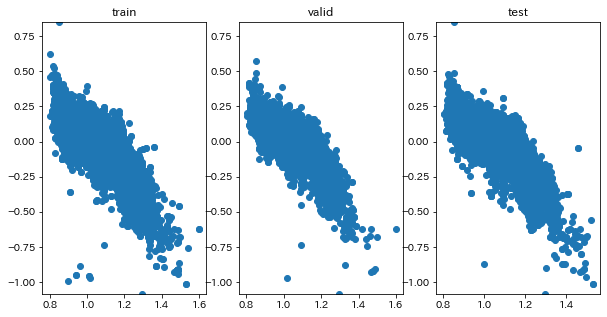

In [26]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - np.array(y_train).reshape(-1,1)
error_valid = y_valid_pred - np.array(y_valid).reshape(-1,1)
error_test = y_test_pred - np.array(y_test).reshape(-1,1)

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [27]:
sound()

NameError: name 'sound' is not defined

In [ ]:
def sound():
    !rundll32 user32.dll,MessageBeep